In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal




In [14]:
rng = np.random.default_rng()
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power),size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

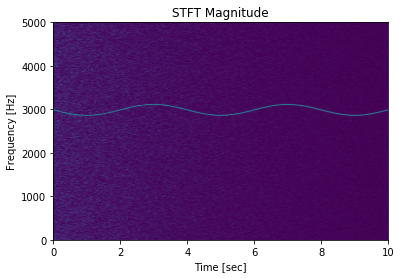

In [15]:
f, t, Zxx = signal.stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Construction des différents blocs du NN

In [16]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#### 1-Construction de la Depthwise convolution

In [10]:
import keras
import tensorflow as tf
import keras.layers as layers
import keras.activations as activations
import numpy as np


In [6]:
x = np.random.rand(7,128,1)
#print(x)
y = tf.keras.layers.Conv1D(32, 3, input_shape=[3,128])(x)
print(np.shape(y))


(7, 126, 32)


In [11]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
        self.kernel = kernel_size
        self.l1= tf.keras.Sequential()
        self.conv1d_1 = tf.keras.layers.Conv1D(out_channels , 1, input_shape = shape)
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_2 = layers.Conv1D(out_channels,kernel_size, input_shape =(None,out_channels),strides = stride, groups = out_channels)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):

        x = self.l1(x)
        x = self.conv1d_1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        print(np.shape(x))

        pad = np.zeros((np.shape(x)[0],self.kernel//2,np.shape(x)[2]))
        pad_x = np.concatenate((pad,x.numpy(),pad),axis=1)
        y = self.conv1d_2(pad_x)
        y = self.norm2(y)
        y = self.relu2(y)

        return y



In [12]:
dpconv = DepthwiseSeparableConv1d(128, 60, 4, 3)

y = dpconv(x)

print(np.shape(y))

(7, 128, 60)
(7, 43, 60)


In [ ]:
x = np.zeros((7,2,60))
y =  np.zeros((7,128,60))

np.shape(np.concatenate((x,y),axis = 1))

(7, 130, 60)

#### 2-Construction du bloc GRU

In [18]:
## fonction de départ

class GRUBlock2(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, bidirectional):
        super(GRUBlock, self).__init__()
        self.GRU = nn.GRU(in_channels, hidden_size, bidirectional=bidirectional)
        
        self.conv = nn.Sequential(nn.Conv1d(hidden_size * (2 if bidirectional==True else 1), out_channels, kernel_size = 1),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(inplace=True))

    def forward(self, x):
        output,h = self.GRU(x)
        output = output.transpose(1,2)
        output = self.conv(output)
        return output

In [19]:
# Traduit en keras

class GRUBlock(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, bidirectional):

        super(GRUBlock, self).__init__()



        self.GRU = layers.GRU(hidden_size)

        if bidirectional:
            self.bidir = layers.Bidirectional(self.GRU)
        else:
            self.bidir = self.GRU
        ###
        self.conv = nn.Sequential(nn.Conv1d(hidden_size * (2 if bidirectional==True else 1), out_channels, kernel_size = 1),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(inplace=True))

    def forward(self, x):
        output,h = self.GRU(x)
        output = output.transpose(1,2)
        output = self.conv(output)
        return output